#Packages

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import random
from torchvision.utils import make_grid
import torch.nn.functional as F
from tqdm import tqdm 
from torch.utils.data import random_split
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploring the Data

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)
explore_ds = DataLoader(dataset,batch_size = 1,num_workers=2) 

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [ ]:
data = iter(explore_ds) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")
print("Total No of Images in EMNIST dataset:", len(dataset) + len(test_dataset))
print("No of images in Training dataset:    ",len(dataset))
print("No of images in Testing dataset:     ",len(test_dataset))

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([1, 1, 28, 28]), torch.Size([1])
Labels: tensor([35])

Total No of Images in EMNIST dataset: 814255
No of images in Training dataset:     697932
No of images in Testing dataset:      116323


In [ ]:
l = dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  62
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# This helper funcation convert the output index [0-61] into character [0-9],[A-Z],[a-z]

def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)


# This is reverse of above function. Convert character [0-9],[A-Z],[a-z] into index [0-61]
def to_index(char):
    if ord(char)<59:
        return ord(char)-48
    elif ord(char)<95:
        return ord(char)-55
    else:
        return ord(char)-61

In [ ]:
def show_example(data):
    img, label = data
    print("Label: ("+to_char(label)+")")
    plt.imshow(img[0], cmap="gray")

Label: (9)


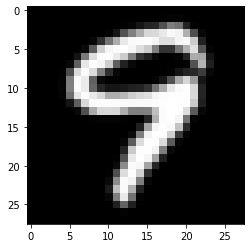

In [ ]:
show_example(dataset[random.randrange(len(dataset))])

# Basic setups

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
class CharacterClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print()
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        print()

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
 
    for epoch in tqdm(range(epochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader,
                              desc="iteration",
                              unit="%",
                              disable=True):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# AlexNet

In [ ]:
model_save_name = 'emnist-alexnet.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.Resize((224,224)),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 400

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


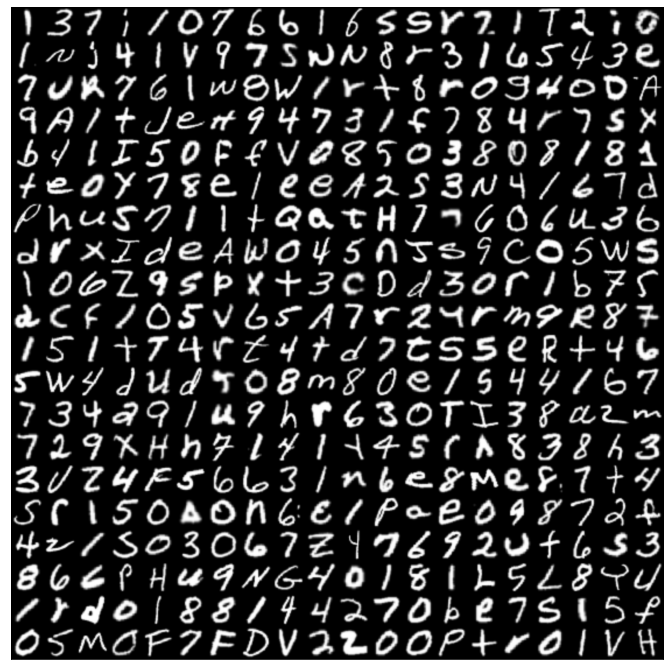

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(train_dl)     


Validation Batch: 


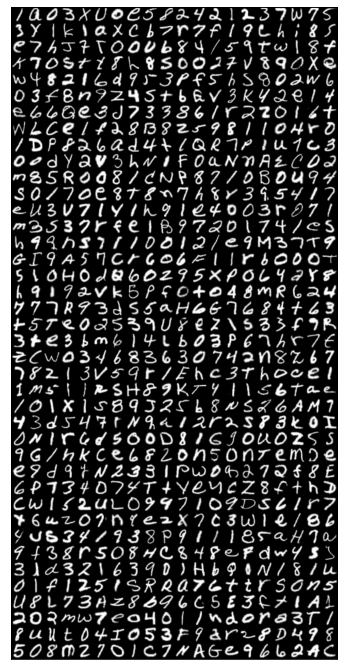

In [ ]:
print('Validation Batch: ')
show_batch(val_dl)

In [ ]:
class AlexNet(CharacterClassificationBase):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(AlexNet(num_classes = len(l)), device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Evaluate model without training

In [ ]:
result = [evaluate(model, val_dl)]
result

[{'val_acc': 0.0037365613970905542, 'val_loss': 4.127875328063965}]

In [ ]:
train_model = True

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [ ]:
%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Training the model... 




Epoch:  12%|█▎        | 1/8 [07:29<52:25, 449.41s/epoch]


Epoch [0], last_lr: 0.00396, train_loss: 0.6916, val_loss: 0.4611, val_acc: 0.8368



Epoch:  25%|██▌       | 2/8 [15:04<45:18, 453.02s/epoch]


Epoch [1], last_lr: 0.00936, train_loss: 0.6260, val_loss: 0.5618, val_acc: 0.8115



Epoch:  38%|███▊      | 3/8 [22:36<37:40, 452.20s/epoch]


Epoch [2], last_lr: 0.00972, train_loss: 0.6582, val_loss: 0.5053, val_acc: 0.8225



Epoch:  50%|█████     | 4/8 [30:08<30:09, 452.28s/epoch]


Epoch [3], last_lr: 0.00812, train_loss: 0.5952, val_loss: 0.4679, val_acc: 0.8312



Epoch:  62%|██████▎   | 5/8 [37:36<22:32, 450.72s/epoch]


Epoch [4], last_lr: 0.00556, train_loss: 0.5351, val_loss: 0.4218, val_acc: 0.8487



Epoch:  75%|███████▌  | 6/8 [45:02<14:58, 449.19s/epoch]


Epoch [5], last_lr: 0.00283, train_loss: 0.4686, val_loss: 0.3800, val_acc: 0.8589



Epoch:  88%|████████▊ | 7/8 [52:29<07:28, 448.54s/epoch]


Epoch [6], last_lr: 0.00077, train_loss: 0.4110, val_loss: 0.3509, val_acc: 0.8690



Epoch: 100%|██████████| 8/8 [59:59<00:00, 449.94s/epoch]


Epoch [7], last_lr: 0.00000, train_loss: 0.3716, val_loss: 0.3389, val_acc: 0.8728

CPU times: user 15min 2s, sys: 5min 2s, total: 20min 4s
Wall time: 59min 59s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+'alexnet_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+'alexnet_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+'alexnet_history_train_losses.txt', train_losses)
      np.savetxt(path+'alexnet_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+'alexnet_history_train_losses.txt')
      val_losses = np.loadtxt(path+'alexnet_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+'alexnet_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+'alexnet_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

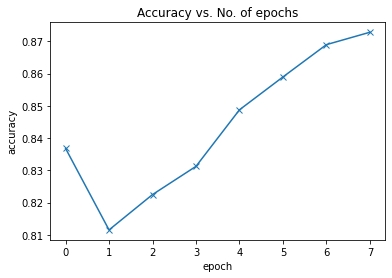

In [ ]:
if train_model:
  plot_accuracies(history)

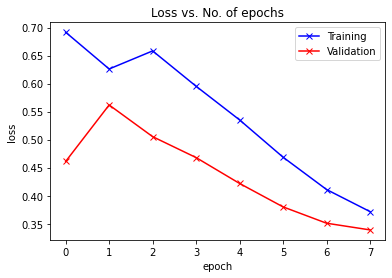

In [ ]:
if train_model:
  plot_losses(history)

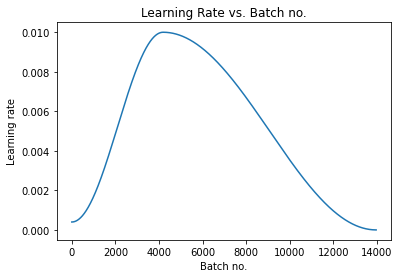

In [ ]:
if train_model:
  plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8727961778640747
The final Loss of model on Test Dataset:     0.33891603350639343


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  

# ResNet


In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 400

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


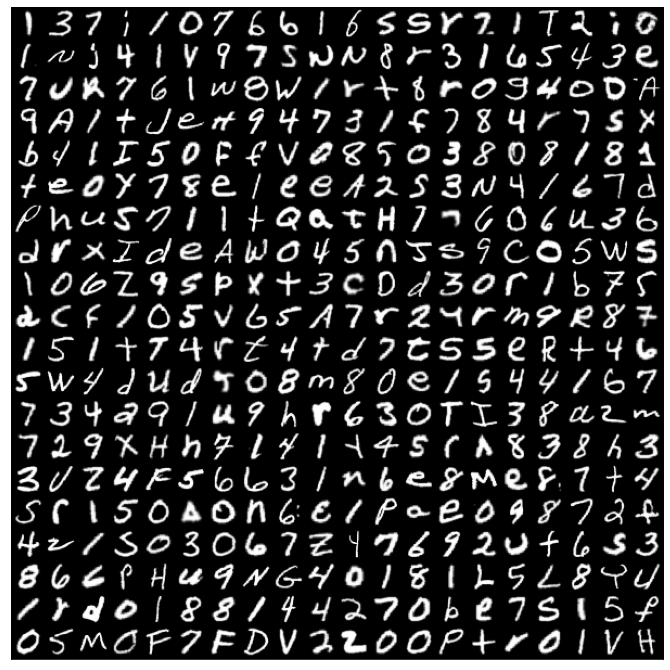

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(train_dl)     


Validation Batch: 


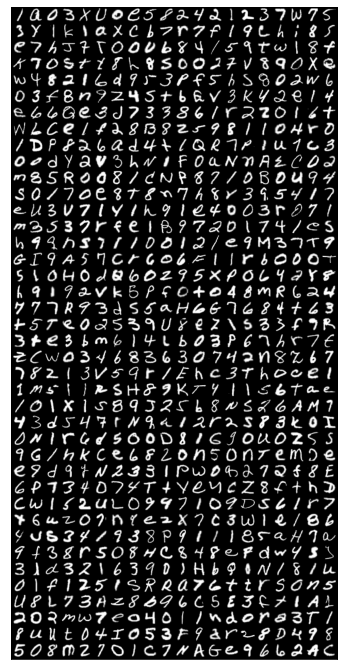

In [ ]:
print('Validation Batch: ')
show_batch(val_dl)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(CharacterClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(7), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out



## ResNet9

In [ ]:
model_save_name = 'emnist-resnet9.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(ResNet9(1, 62), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
result = [evaluate(model, val_dl)]
result

[{'val_acc': 0.013787532225251198, 'val_loss': 4.1307573318481445}]

In [ ]:
train_model = True

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [ ]:
%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Training the model... 




Epoch:  12%|█▎        | 1/8 [03:59<27:54, 239.18s/epoch]


Epoch [0], last_lr: 0.00396, train_loss: 0.5380, val_loss: 0.4769, val_acc: 0.8224



Epoch:  25%|██▌       | 2/8 [07:58<23:54, 239.12s/epoch]


Epoch [1], last_lr: 0.00936, train_loss: 0.4358, val_loss: 0.4563, val_acc: 0.8352



Epoch:  38%|███▊      | 3/8 [11:57<19:55, 239.11s/epoch]


Epoch [2], last_lr: 0.00972, train_loss: 0.4393, val_loss: 0.4569, val_acc: 0.8430



Epoch:  50%|█████     | 4/8 [15:56<15:56, 239.18s/epoch]


Epoch [3], last_lr: 0.00812, train_loss: 0.4239, val_loss: 0.4176, val_acc: 0.8483



Epoch:  62%|██████▎   | 5/8 [19:55<11:57, 239.23s/epoch]


Epoch [4], last_lr: 0.00556, train_loss: 0.4041, val_loss: 0.3725, val_acc: 0.8617



Epoch:  75%|███████▌  | 6/8 [23:55<07:58, 239.26s/epoch]


Epoch [5], last_lr: 0.00283, train_loss: 0.3780, val_loss: 0.3570, val_acc: 0.8679



Epoch:  88%|████████▊ | 7/8 [27:54<03:59, 239.27s/epoch]


Epoch [6], last_lr: 0.00077, train_loss: 0.3485, val_loss: 0.3271, val_acc: 0.8773



Epoch: 100%|██████████| 8/8 [31:53<00:00, 239.23s/epoch]


Epoch [7], last_lr: 0.00000, train_loss: 0.3215, val_loss: 0.3172, val_acc: 0.8809

CPU times: user 22min 53s, sys: 7min 46s, total: 30min 39s
Wall time: 31min 53s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+'resnet9_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+'resnet9_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+'resnet9_history_train_losses.txt', train_losses)
      np.savetxt(path+'resnet9_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+'resnet9_history_train_losses.txt')
      val_losses = np.loadtxt(path+'resnet9_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+'resnet9_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+'resnet9_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

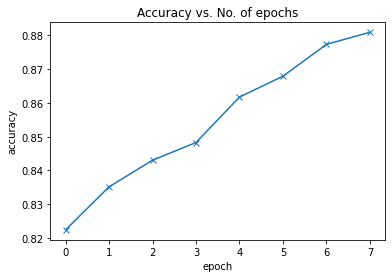

In [ ]:
if train_model:
  plot_accuracies(history)

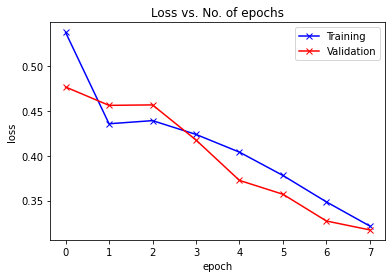

In [ ]:
if train_model:
  plot_losses(history)

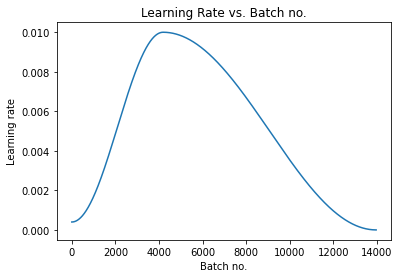

In [ ]:
if train_model:
  plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8809028267860413
The final Loss of model on Test Dataset:     0.3172011971473694


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  

## ResNet50

In [ ]:
model_save_name = 'emnist-resnet50.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
class Block(CharacterClassificationBase):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(CharacterClassificationBase):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(ResNet50(img_channels=1, num_classes=62), device)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
result = [evaluate(model, val_dl)]
result

[{'val_acc': 0.005372232291847467, 'val_loss': 4.124775409698486}]

In [ ]:
train_model = True

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [ ]:
%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Training the model... 




Epoch:  12%|█▎        | 1/8 [03:49<26:45, 229.42s/epoch]


Epoch [0], last_lr: 0.00396, train_loss: 0.5686, val_loss: 0.4663, val_acc: 0.8329



Epoch:  25%|██▌       | 2/8 [07:39<23:00, 230.01s/epoch]


Epoch [1], last_lr: 0.00936, train_loss: 0.4479, val_loss: 0.5450, val_acc: 0.8145



Epoch:  38%|███▊      | 3/8 [11:29<19:10, 230.01s/epoch]


Epoch [2], last_lr: 0.00972, train_loss: 0.4568, val_loss: 0.4894, val_acc: 0.8315



Epoch:  50%|█████     | 4/8 [15:19<15:20, 230.01s/epoch]


Epoch [3], last_lr: 0.00812, train_loss: 0.4384, val_loss: 0.5072, val_acc: 0.8253



Epoch:  62%|██████▎   | 5/8 [19:09<11:29, 229.99s/epoch]


Epoch [4], last_lr: 0.00556, train_loss: 0.4181, val_loss: 0.5126, val_acc: 0.8250



Epoch:  75%|███████▌  | 6/8 [22:59<07:39, 230.00s/epoch]


Epoch [5], last_lr: 0.00283, train_loss: 0.3879, val_loss: 0.3753, val_acc: 0.8625



Epoch:  88%|████████▊ | 7/8 [26:49<03:49, 229.96s/epoch]


Epoch [6], last_lr: 0.00077, train_loss: 0.3542, val_loss: 0.3437, val_acc: 0.8711



Epoch: 100%|██████████| 8/8 [30:39<00:00, 229.98s/epoch]


Epoch [7], last_lr: 0.00000, train_loss: 0.3257, val_loss: 0.3285, val_acc: 0.8758



CPU times: user 23min 11s, sys: 6min 24s, total: 29min 36s
Wall time: 30min 40s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+'resnet50_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+'resnet50_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+'resnet50_history_train_losses.txt', train_losses)
      np.savetxt(path+'resnet50_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+'resnet50_history_train_losses.txt')
      val_losses = np.loadtxt(path+'resnet50_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+'resnet50_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+'resnet50_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

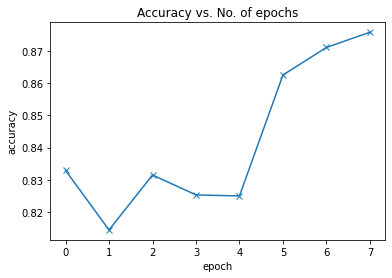

In [ ]:
if train_model:
  plot_accuracies(history)

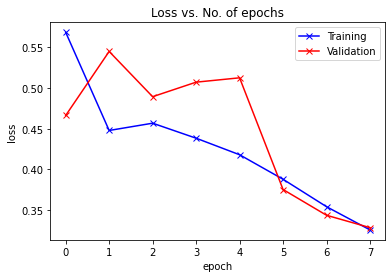

In [ ]:
if train_model:
  plot_losses(history)

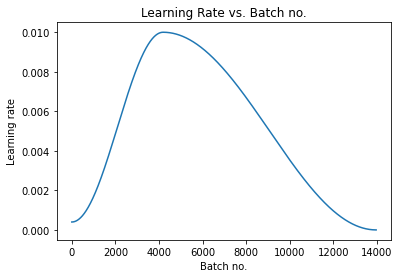

In [ ]:
if train_model:
  plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.875771164894104
The final Loss of model on Test Dataset:     0.3285129964351654


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  

# VGGNet

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.Resize((224,224)),
                        tt.ToTensor()
                
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 100

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


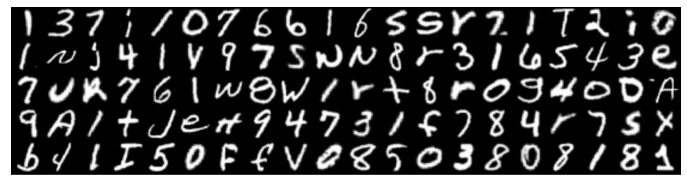

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(train_dl)     


Validation Batch: 


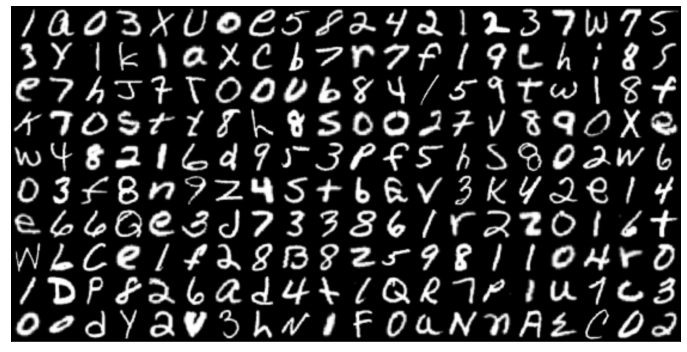

In [ ]:
print('Validation Batch: ')
show_batch(val_dl)

In [ ]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(CharacterClassificationBase):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=True):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model



def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model



def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model



def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model



def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model



def vgg16_bn(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model



def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model



def vgg19_bn(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model

## VGG11

In [ ]:
model_save_name = 'emnist-vgg11.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(vgg11(num_classes = len(l)), device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Evaluate model without training

In [ ]:
result = [evaluate(model, val_dl)]
result

KeyboardInterrupt: ignored

In [ ]:
train_model = False

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [ ]:
%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Using trained pratameters

<All keys matched successfully>

CPU times: user 159 ms, sys: 384 ms, total: 543 ms
Wall time: 6.08 s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+'vgg11_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+'vgg11_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+'vgg11_history_train_losses.txt', train_losses)
      np.savetxt(path+'vgg11_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+'vgg11_history_train_losses.txt')
      val_losses = np.loadtxt(path+'vgg11_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+'vgg11_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+'vgg11_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

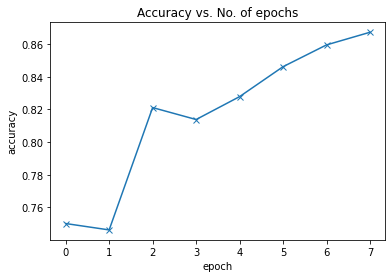

In [ ]:
plot_accuracies(history)

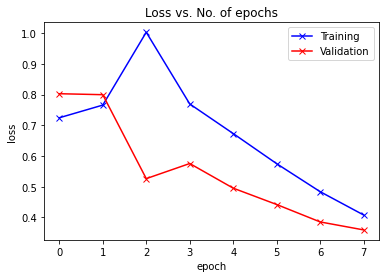

In [ ]:
plot_losses(history)

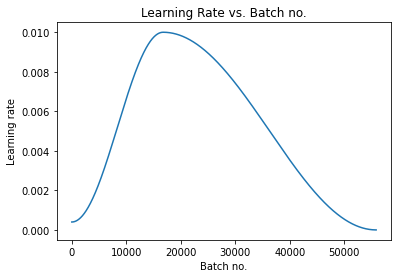

In [ ]:
plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8674021363258362
The final Loss of model on Test Dataset:     0.3594854474067688


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  

## VGG16

In [ ]:
model_save_name = 'emnist-vgg16.pth'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(vgg16(num_classes = len(l)), device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Evaluate model without training

In [ ]:
result = [evaluate(model, val_dl)]
result

[{'val_acc': 0.010481098666787148, 'val_loss': 4.1273722648620605}]

In [ ]:
train_model = True

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [ ]:

%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Training the model... 




Epoch:  12%|█▎        | 1/8 [2:07:52<14:55:09, 7672.78s/epoch]


Epoch [0], last_lr: 0.00396, train_loss: 0.7748, val_loss: 0.5832, val_acc: 0.8050



Epoch:  25%|██▌       | 2/8 [4:15:00<12:44:37, 7646.26s/epoch]


Epoch [1], last_lr: 0.00936, train_loss: 0.7987, val_loss: 0.7586, val_acc: 0.7579



Epoch:  38%|███▊      | 3/8 [6:22:06<10:36:24, 7636.93s/epoch]


Epoch [2], last_lr: 0.00972, train_loss: 0.8398, val_loss: 0.6275, val_acc: 0.7976



Epoch:  50%|█████     | 4/8 [8:29:12<8:28:50, 7632.65s/epoch] 


Epoch [3], last_lr: 0.00812, train_loss: 0.8538, val_loss: 0.5398, val_acc: 0.8121



Epoch:  62%|██████▎   | 5/8 [10:36:18<6:21:31, 7630.36s/epoch]


Epoch [4], last_lr: 0.00556, train_loss: 0.6742, val_loss: 0.5011, val_acc: 0.8270



Epoch:  75%|███████▌  | 6/8 [12:43:23<4:14:17, 7628.53s/epoch]


Epoch [5], last_lr: 0.00283, train_loss: 0.5669, val_loss: 0.4228, val_acc: 0.8487



Epoch:  88%|████████▊ | 7/8 [14:50:32<2:07:08, 7628.61s/epoch]


Epoch [6], last_lr: 0.00077, train_loss: 0.4747, val_loss: 0.3769, val_acc: 0.8617



Epoch: 100%|██████████| 8/8 [16:57:42<00:00, 7632.78s/epoch]


Epoch [7], last_lr: 0.00000, train_loss: 0.4026, val_loss: 0.3570, val_acc: 0.8674

CPU times: user 16h 49min 9s, sys: 7min 32s, total: 16h 56min 41s
Wall time: 16h 57min 42s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+'vgg16_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+'vgg16_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+'vgg16_history_train_losses.txt', train_losses)
      np.savetxt(path+'vgg16_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+'vgg16_history_train_losses.txt')
      val_losses = np.loadtxt(path+'vgg16_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+'vgg16_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+'vgg16_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

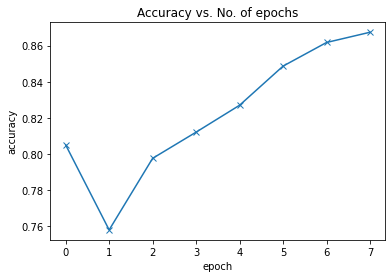

In [ ]:
if train_model:
  plot_accuracies(history)

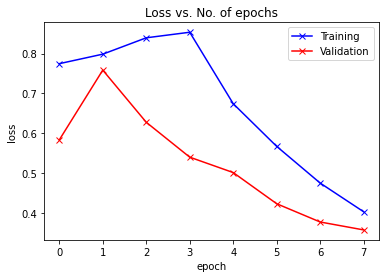

In [ ]:
if train_model:
  plot_losses(history)

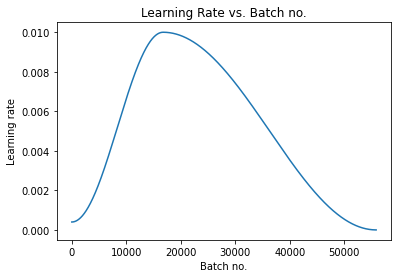

In [ ]:
if train_model:
  plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8674074411392212
The final Loss of model on Test Dataset:     0.3570401072502136


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  

# My Net

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.RandomRotation(degrees=(-5,5)),
                        tt.RandomPerspective(distortion_scale=0.05, p=1),
                        tt.ToTensor(),
                        ])
test_transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = test_transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 500
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 64

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


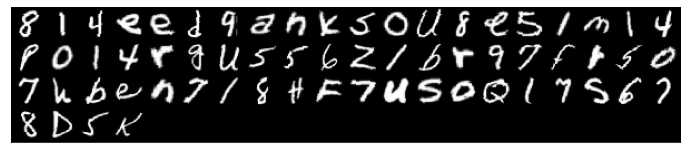

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(train_dl)     


Validation Batch: 


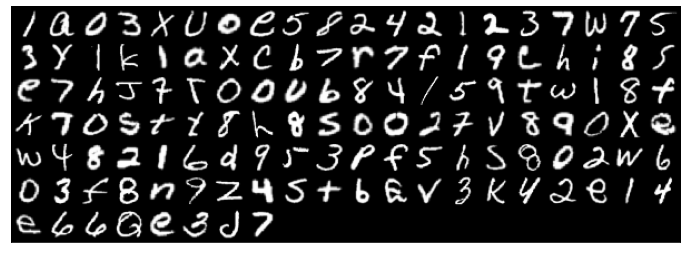

In [ ]:
print('Validation Batch: ')
show_batch(val_dl)

In [ ]:
model_save_name = 'emnist-mynet.pth'
model_name = 'mynet'
path = F"/content/drive/MyDrive/Colab Notebooks/Data/" 

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(CharacterClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(7), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out



In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(ResNet9(1, len(l)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
train_model = False

In [ ]:
epochs = 30
max_lr = 0.02
grad_clip = 0.2
weight_decay = 1e-8
opt_func = torch.optim.Adam
history = []

In [ ]:
%%time
if train_model:
    print("Training the model... \n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load(path + model_save_name, map_location=get_default_device())))
    print()

Using trained pratameters

<All keys matched successfully>

CPU times: user 35.2 ms, sys: 17.2 ms, total: 52.4 ms
Wall time: 3.42 s


In [ ]:
def plot_accuracies(history):
    if train_model:
      accuracies = [x['val_acc'] for x in history]
      np.savetxt(path+model_name+'_history_val_acc.txt', accuracies)
    else:
      accuracies = np.loadtxt(path+model_name+'_history_val_acc.txt')
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    if train_model:
      train_losses = [x.get('train_loss') for x in history]
      val_losses = [x['val_loss'] for x in history]
      np.savetxt(path+model_name+'_history_train_losses.txt', train_losses)
      np.savetxt(path+model_name+'_history_val_losses.txt', val_losses)
    else:
      train_losses = np.loadtxt(path+model_name+'_history_train_losses.txt')
      val_losses = np.loadtxt(path+model_name+'_history_val_losses.txt')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    if train_model:
      lrs = np.concatenate([x.get('lrs', []) for x in history])
      np.savetxt(path+model_name+'_history_lrs.txt', lrs)
    else:
      lrs = np.loadtxt(path+model_name+'_history_lrs.txt')
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

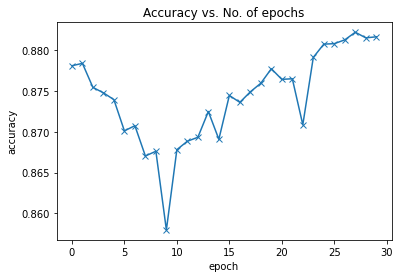

In [ ]:
plot_accuracies(history)

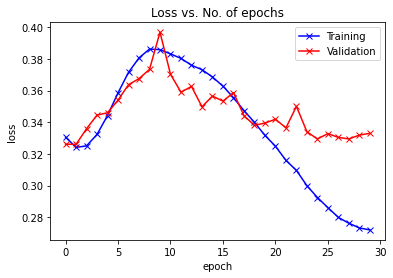

In [ ]:
plot_losses(history)

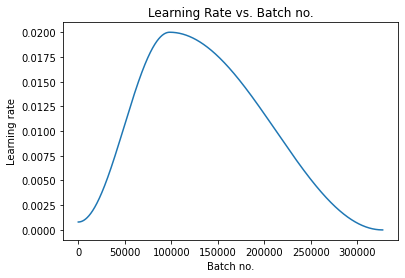

In [ ]:
plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8833850026130676
The final Loss of model on Test Dataset:     0.3278081715106964


Saving model

In [ ]:
if train_model:
  torch.save(model.state_dict(), path + model_save_name)
  

# Testing


## Without transformation

In [ ]:
transform = tt.Compose([
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 4

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


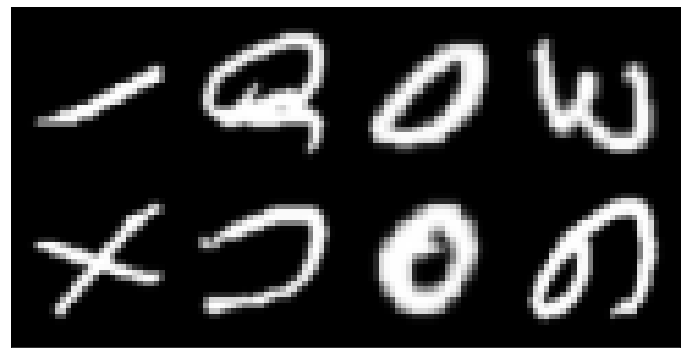

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(val_dl)     


## With transformation

In [ ]:
transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                        lambda img: tt.functional.hflip(img),
                        tt.ToTensor(),
                        ])
dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=True,
                 transform = transform)
test_dataset = EMNIST(root='data/',
                 split='byclass',
                 download=True,
                 train=False,
                 transform = transform)

In [ ]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [ ]:
batch_size = 4

train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size*2, num_workers=2)


Training Batch: 


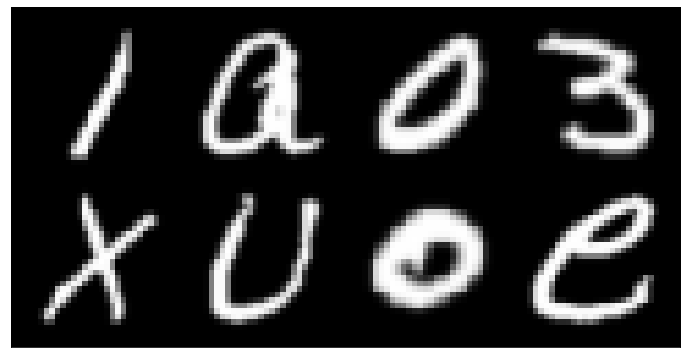

In [ ]:
# Lets see a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
        break
print('Training Batch: ')
show_batch(val_dl)     
